In [1]:
# ----------------------------------------------
# 🧠 STEP 1: IMPORTS & SETUP
# ----------------------------------------------
import os, json, shutil, zipfile
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoTokenizer, AutoModel
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


✅ Using device: cuda


In [2]:
# ----------------------------------------------
# 📦 STEP 2: COSMOS DATASET (WITH CACHED CAPTIONS)
# ----------------------------------------------
class CosmosTrainDataset(Dataset):
    def __init__(self, json_path, image_dir, sbert_encoder, transform=None):
        with open(json_path, 'r') as f:
            self.data = [json.loads(line) for line in f if line.strip()]
        self.image_dir = image_dir
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        # Encode captions ONCE
        print("⚙️ Encoding all captions with SBERT (this may take 2-3 minutes)...")
        self.caption_embeddings = []
        all_captions = [item['articles'][0]['caption'] for item in self.data]

        batch_size = 64
        for i in tqdm(range(0, len(all_captions), batch_size)):
            batch = all_captions[i:i+batch_size]
            emb = sbert_encoder(batch)
            self.caption_embeddings.append(emb.cpu())

        self.caption_embeddings = torch.cat(self.caption_embeddings, dim=0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img_filename = os.path.basename(item['img_local_path'])
        img_path = os.path.join(self.image_dir, img_filename)
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        caption_embedding = self.caption_embeddings[idx]
        return image, caption_embedding


In [3]:
# ----------------------------------------------
# ✍️ STEP 3: SBERT ENCODER FUNCTION
# ----------------------------------------------
model_path = "/kaggle/input/all-minilm-l6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
text_encoder = AutoModel.from_pretrained(model_path, local_files_only=True).to(device)

def encode_sbert(captions):
    inputs = tokenizer(captions, padding=True, truncation=True, return_tensors="pt", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = text_encoder(**inputs)
        attn_mask = inputs['attention_mask']
        token_embeddings = outputs.last_hidden_state
        input_mask_expanded = attn_mask.unsqueeze(-1).expand(token_embeddings.size())
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask  # shape: [batch_size, 384]


2025-04-29 05:13:19.658119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745903599.680593     126 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745903599.687352     126 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# ----------------------------------------------
# 📂 STEP 4: LOAD DATA (SUBSET + CACHE)
# ----------------------------------------------
json_path = '/kaggle/input/cos-mos/test_and_annotations/test_&_annotations/cosmos_anns_acm/cosmos_anns_acm/acm_anns/train_data.json'
image_dir = '/kaggle/input/cosmos-dataset/images-train-001/train'

# Full dataset with encoded captions
full_dataset = CosmosTrainDataset(json_path, image_dir, encode_sbert)

# ⚡ Train on 5,000 samples only (speed!)
train_dataset = Subset(full_dataset, range(5000))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


⚙️ Encoding all captions with SBERT (this may take 2-3 minutes)...


  0%|          | 0/2528 [00:00<?, ?it/s]

In [5]:
# # ----------------------------------------------
# 🖼️ STEP 5: IMAGE ENCODER (RESNET)
# ----------------------------------------------
resnet = models.resnet50(weights=None)
resnet.fc = nn.Identity()
resnet = resnet.to(device)
resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
# # ----------------------------------------------
# 🧠 STEP 6–7: MATCHING MODEL + RESUME CHECKPOINT
# ----------------------------------------------

import torch.nn as nn
import torch.optim as optim
import os

# Define the matching model
class MatchingMLP(nn.Module):
    def __init__(self, img_dim=2048, txt_dim=384, hidden_dim=512):
        super(MatchingMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim + txt_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, img_feat, txt_feat):
        combined = torch.cat((img_feat, txt_feat), dim=1)
        return self.model(combined)

# Initialize model, optimizer, loss
model = MatchingMLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

# Resume from checkpoint if available
start_epoch = 0
checkpoint_path = "/kaggle/input/matching-model-checkpoint/matching_model_latest.pth"  # change if needed

if os.path.exists(checkpoint_path):
    print("🔁 Resuming from checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"✅ Resumed from epoch {start_epoch}")
else:
    print("🆕 Starting fresh training...")


🆕 Starting fresh training...


In [7]:
# # ----------------------------------------------
# 🚀 STEP 8: TRAINING LOOP (With Save + Display)
# ----------------------------------------------
num_epochs = 3
model.train()

for epoch in range(start_epoch, num_epochs):
    total_loss = 0

    # images: [B, 3, 224, 224], cap_feats: [B, 384] (already encoded)
    for images, cap_feats in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        cap_feats = cap_feats.to(device)

        # 🔍 Extract image features (ResNet)
        with torch.no_grad():
            img_feats = resnet(images)

        # ✅ Positive and negative pairs
        pos_labels = torch.ones(len(images)).to(device)
        shuffled = torch.randperm(len(images))
        neg_cap_feats = cap_feats[shuffled]
        neg_labels = torch.zeros(len(images)).to(device)

        all_img_feats = torch.cat([img_feats, img_feats], dim=0)
        all_cap_feats = torch.cat([cap_feats, neg_cap_feats], dim=0)
        all_labels = torch.cat([pos_labels, neg_labels], dim=0)

        # 🔁 Forward + Backward
        preds = model(all_img_feats, all_cap_feats).squeeze(1)
        loss = criterion(preds, all_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # ✅ End of Epoch
    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1} completed | Avg Loss: {avg_loss:.4f}")

    # 💾 Save latest checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }, "/kaggle/working/matching_model_latest.pth")

    # 🔁 Copy for sidebar download
    shutil.copy("/kaggle/working/matching_model_latest.pth",
                f"/kaggle/working/matching_model_epoch{epoch+1}.pth")

    # 📦 Optional: Save zip for download
    with zipfile.ZipFile("/kaggle/working/matching_model_checkpoint.zip", 'w') as zipf:
        zipf.write("/kaggle/working/matching_model_latest.pth",
                   arcname=f"matching_model_epoch{epoch+1}.pth")

    print("💾 Checkpoint saved + zipped. Available in sidebar.")


Epoch 1/3:   0%|          | 0/1250 [00:00<?, ?it/s]

✅ Epoch 1 completed | Avg Loss: 12.6201
💾 Checkpoint saved + zipped. Available in sidebar.


Epoch 2/3:   0%|          | 0/1250 [00:00<?, ?it/s]

✅ Epoch 2 completed | Avg Loss: 0.7536
💾 Checkpoint saved + zipped. Available in sidebar.


Epoch 3/3:   0%|          | 0/1250 [00:00<?, ?it/s]

✅ Epoch 3 completed | Avg Loss: 0.7532
💾 Checkpoint saved + zipped. Available in sidebar.


In [8]:
import os, json, zipfile
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# STEP 1: DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# STEP 2: COSMOS DATASET
class CosmosTrainDataset(Dataset):
    def __init__(self, json_path, image_dir, transform=None):
        with open(json_path, 'r') as f:
            self.data = [json.loads(line) for line in f if line.strip()]

        self.image_dir = image_dir
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img_filename = os.path.basename(item['img_local_path'])
        img_path = os.path.join(self.image_dir, img_filename)
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        caption = item['articles'][0]['caption']
        return image, caption

# STEP 3: LOAD DATASET
json_path = '/kaggle/input/cos-mos/test_and_annotations/test_&_annotations/cosmos_anns_acm/cosmos_anns_acm/acm_anns/train_data.json'
image_dir = '/kaggle/input/cosmos-dataset/images-train-001/train'
train_dataset = CosmosTrainDataset(json_path, image_dir)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# STEP 4: SBERT (LOCAL)
model_path = "/kaggle/input/all-minilm-l6-v2"
text_tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
text_encoder = AutoModel.from_pretrained(model_path, local_files_only=True).to(device)

def encode_captions(captions):
    inputs = text_tokenizer(captions, padding=True, truncation=True, return_tensors="pt", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = text_encoder(**inputs)
        attn_mask = inputs['attention_mask']
        token_embeddings = outputs.last_hidden_state
        input_mask_expanded = attn_mask.unsqueeze(-1).expand(token_embeddings.size())
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask  # [batch_size, 384]

# STEP 5: RESNET (LOCAL, NO INTERNET)
resnet = models.resnet50(weights=None)
resnet.fc = nn.Identity()
resnet = resnet.to(device)
resnet.eval()

# STEP 6: MATCHING MODEL
class MatchingMLP(nn.Module):
    def __init__(self, img_dim=2048, txt_dim=384, hidden_dim=512):
        super(MatchingMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim + txt_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, img_feat, txt_feat):
        combined = torch.cat((img_feat, txt_feat), dim=1)
        return self.model(combined)

model = MatchingMLP().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# STEP 7: PRECOMPUTE CAPTION EMBEDDINGS AND SAVE TO DISK
print("⚡ Precomputing all caption embeddings and saving to disk...")

caption_embeddings = []

for idx, (_, caption) in tqdm(enumerate(train_dataset), desc="Encoding captions", total=len(train_dataset)):
    emb = encode_captions([caption])  # SBERT expects batch
    caption_embeddings.append(emb.squeeze(0).cpu())  # save to CPU to save VRAM

# Save all to a single file
caption_embeddings = torch.stack(caption_embeddings)
torch.save(caption_embeddings, "/kaggle/working/caption_embeddings_all.pt")
print("✅ All caption embeddings saved to /kaggle/working/caption_embeddings_all.pt")




        

✅ Using device: cuda
⚡ Precomputing all caption embeddings and saving to disk...


Encoding captions: 100%|██████████| 161754/161754 [42:05<00:00, 64.06it/s]  


✅ All caption embeddings saved to /kaggle/working/caption_embeddings_all.pt


In [9]:
# STEP 7.5: LOAD ALL CAPTION EMBEDDINGS INTO MEMORY
print("📥 Loading caption embeddings into memory...")
caption_embeddings = torch.load("/kaggle/working/caption_embeddings_all.pt").to(device)

📥 Loading caption embeddings into memory...


/tmp/ipykernel_126/3304565360.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  caption_embeddings = torch.load("/kaggle/working/caption_embeddings_all.pt").to(device)


Epoch 1/10: 100%|██████████| 40439/40439 [41:31<00:00, 16.23it/s] 



✅ Epoch 1 completed
Avg Loss         : 0.7284
Accuracy         : 0.5000
F1 Score         : 0.6667
Average Precision: 0.5000

💾 Saved: matching_model_epoch1_complete.pth


Epoch 2/10: 100%|██████████| 40439/40439 [38:32<00:00, 17.49it/s] 



✅ Epoch 2 completed
Avg Loss         : 0.6931
Accuracy         : 0.5000
F1 Score         : 0.6667
Average Precision: 0.5001

💾 Saved: matching_model_epoch2_complete.pth


Epoch 3/10: 100%|██████████| 40439/40439 [37:30<00:00, 17.97it/s]  



✅ Epoch 3 completed
Avg Loss         : 0.6931
Accuracy         : 0.5000
F1 Score         : 0.6667
Average Precision: 0.5000

💾 Saved: matching_model_epoch3_complete.pth


Epoch 4/10: 100%|██████████| 40439/40439 [37:29<00:00, 17.98it/s] 



✅ Epoch 4 completed
Avg Loss         : 0.6931
Accuracy         : 0.5000
F1 Score         : 0.6667
Average Precision: 0.5000

💾 Saved: matching_model_epoch4_complete.pth


Epoch 5/10: 100%|██████████| 40439/40439 [37:35<00:00, 17.93it/s]



✅ Epoch 5 completed
Avg Loss         : 0.6931
Accuracy         : 0.5000
F1 Score         : 0.6667
Average Precision: 0.5000

💾 Saved: matching_model_epoch5_complete.pth


Epoch 6/10: 100%|██████████| 40439/40439 [37:46<00:00, 17.84it/s] 



✅ Epoch 6 completed
Avg Loss         : 0.6931
Accuracy         : 0.5000
F1 Score         : 0.6667
Average Precision: 0.5000

💾 Saved: matching_model_epoch6_complete.pth


Epoch 7/10: 100%|██████████| 40439/40439 [37:47<00:00, 17.83it/s] 



✅ Epoch 7 completed
Avg Loss         : 0.6931
Accuracy         : 0.5000
F1 Score         : 0.6667
Average Precision: 0.5000

💾 Saved: matching_model_epoch7_complete.pth


Epoch 8/10: 100%|██████████| 40439/40439 [37:32<00:00, 17.95it/s] 



✅ Epoch 8 completed
Avg Loss         : 0.6931
Accuracy         : 0.5000
F1 Score         : 0.6667
Average Precision: 0.5000

💾 Saved: matching_model_epoch8_complete.pth


Epoch 9/10: 100%|██████████| 40439/40439 [37:25<00:00, 18.01it/s] 



✅ Epoch 9 completed
Avg Loss         : 0.6931
Accuracy         : 0.5000
F1 Score         : 0.6667
Average Precision: 0.5000

💾 Saved: matching_model_epoch9_complete.pth


Epoch 10/10: 100%|██████████| 40439/40439 [37:42<00:00, 17.87it/s]



✅ Epoch 10 completed
Avg Loss         : 0.6931
Accuracy         : 0.5000
F1 Score         : 0.6667
Average Precision: 0.5000

💾 Saved: matching_model_epoch10_complete.pth


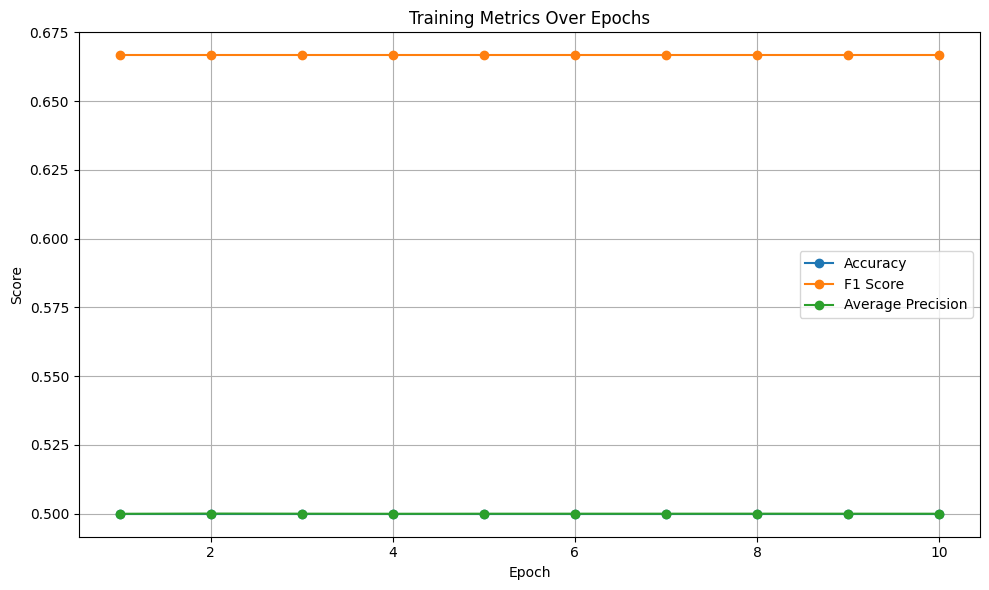

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, average_precision_score
import zipfile

# Containers for tracking metrics
epoch_accs = []
epoch_f1s = []
epoch_aps = []

num_epochs = 10  # You can increase this for more training
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    y_true, y_pred, y_scores = [], [], []

    for step, (images, captions) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        images = images.to(device)
        captions = list(captions)

        # Feature extraction (frozen)
        with torch.no_grad():
            img_feats = resnet(images)

        # Cached caption embeddings
        start_idx = step * train_loader.batch_size
        end_idx = start_idx + len(images)
        cap_feats = caption_embeddings[start_idx:end_idx].to(device)

        # Positive and negative pairs
        pos_labels = torch.ones(len(images)).to(device)
        shuffled = torch.randperm(len(images))
        neg_cap_feats = cap_feats[shuffled]
        neg_labels = torch.zeros(len(images)).to(device)

        all_img_feats = torch.cat([img_feats, img_feats], dim=0)
        all_cap_feats = torch.cat([cap_feats, neg_cap_feats], dim=0)
        all_labels = torch.cat([pos_labels, neg_labels], dim=0)

        # Forward and backward
        preds = model(all_img_feats, all_cap_feats).squeeze(1)
        loss = criterion(preds, all_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Metrics
        prob = preds.sigmoid().detach().cpu().numpy()
        pred = (prob > 0.5).astype(int)
        y_true.extend(all_labels.cpu().numpy())
        y_pred.extend(pred)
        y_scores.extend(prob)

    # Compute Epoch Metrics
    avg_loss = total_loss / len(train_loader)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    ap = average_precision_score(y_true, y_scores)

    epoch_accs.append(acc)
    epoch_f1s.append(f1)
    epoch_aps.append(ap)

    print(f"\n✅ Epoch {epoch+1} completed")
    print(f"Avg Loss         : {avg_loss:.4f}")
    print(f"Accuracy         : {acc:.4f}")
    print(f"F1 Score         : {f1:.4f}")
    print(f"Average Precision: {ap:.4f}\n")

    # Save model checkpoint
    checkpoint_name = f"matching_model_epoch{epoch+1}_complete.pth"
    checkpoint_path = os.path.join("/kaggle/working/", checkpoint_name)

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }, checkpoint_path)

    # Zip checkpoint
    zip_path = checkpoint_path.replace(".pth", ".zip")
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        zipf.write(checkpoint_path, arcname=checkpoint_name)

    print(f"💾 Saved: {checkpoint_name}")

# ---- Plot Metrics After All Epochs ----
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, epoch_accs, label='Accuracy', marker='o')
plt.plot(epochs, epoch_f1s, label='F1 Score', marker='o')
plt.plot(epochs, epoch_aps, label='Average Precision', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Training Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/kaggle/working/training_metrics.png")
plt.show()
